In [1]:
import pandas as pd
from scipy.spatial.distance import pdist,cdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import matplotlib.gridspec as gridspec
import numpy as np
import random 

SEED = 2
random.seed(SEED)
np.random.seed(SEED)

df = pd.read_csv("data/creditcard.csv")

In [2]:
X = np.array(df.drop(columns=["Class"]))
y = df["Class"]

normal_ixs = np.where(y==0)[0]
fraud_ixs = np.where(y==1)[0]

normal_ixs_downsample = np.random.choice(normal_ixs, 5000, replace=False).tolist()
fraud_ixs_downsample = np.random.choice(fraud_ixs, 50, replace=False).tolist()
downsample = normal_ixs_downsample + fraud_ixs_downsample

X_normal = X[normal_ixs_downsample]
X_fraud = X[fraud_ixs_downsample]

X = np.concatenate([X_normal, X_fraud] , axis=0)
y = np.array([1]*5000 + [0] * 50)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=SEED, init='pca',perplexity=60, n_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

In [3]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

# calculates the alpha-statistic of a point with respect to the other points
def alpha_(pts, pt):
    X = np.concatenate([pts, [pt]] , axis=0)
    X = StandardScaler().fit_transform(X)
    y = np.ones(len(pts) + 1)
    y[-1] = -1
    clf = LinearSVC(C=1e12,dual=False)
    clf.fit(X,y)
    if np.all(clf.predict(X) == y):
        return 2 * (1.0 / np.linalg.norm(clf.coef_))/diam(pts[np.where(y==1)])
    else:
        return 0

In [4]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS


og_alphas = []
tsne_alphas = []
pca_alphas = []

for i in tqdm(range(len(X_fraud))):

    og_alphas.append( alpha_(X[:5000], X[5000+i]) )
    tsne_alphas.append( alpha_(X_tsne[:5000], X_tsne[5000+i]) )
    pca_alphas.append( alpha_(X_pca[:5000], X_pca[5000+i]) )
    #tsne_alphas.append( alpha() )


  2%|▏         | 1/50 [00:02<01:41,  2.07s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 80%|████████  | 40/50 [01:15<00:19,  1.98s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 96%|█████████▌| 48/50 [01:28<00:03,  1.87s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


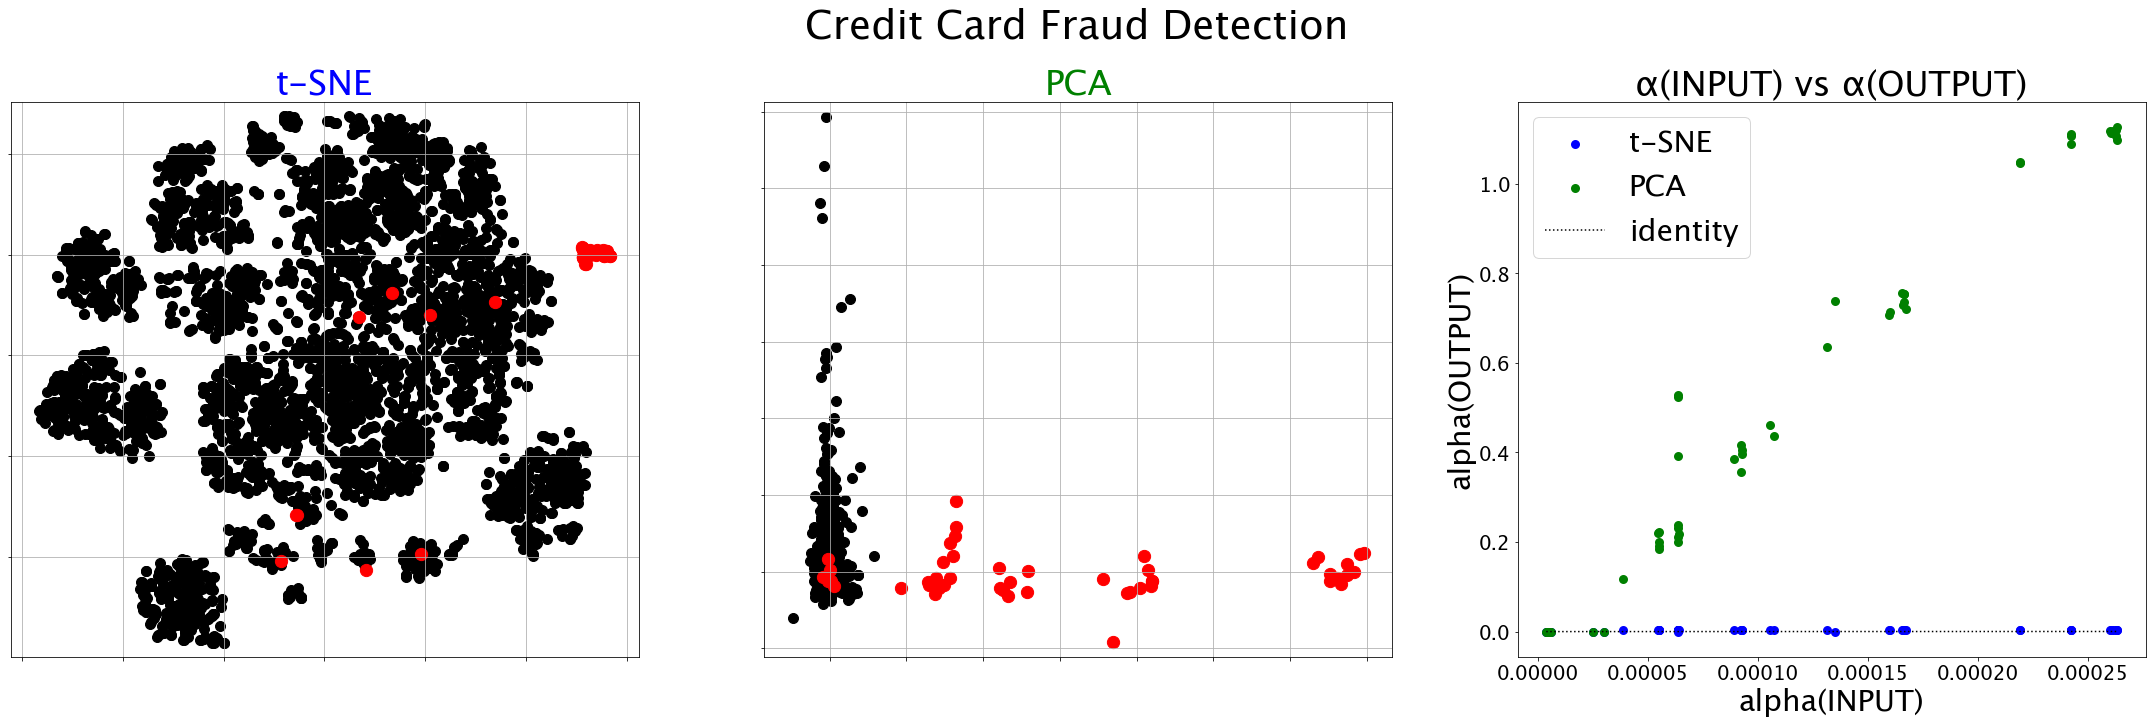

In [5]:
fig, axs = plt.subplots(1,3, figsize=(30,10))


id = [min(og_alphas), max(og_alphas)]

for i in range(2):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].set_title('t-SNE', fontsize=35, color='blue')
axs[0].scatter(X_tsne[:5000, 0], X_tsne[:5000, 1], s=100,  c='black', label="Normal")
axs[0].scatter(X_tsne[5000:, 0], X_tsne[5000:, 1], s=150, label="Fraud", c="red")

axs[1].set_title('PCA', fontsize=35, color='green')
axs[1].scatter(X_pca[:5000, 0], X_pca[:5000, 1], s=100,  c='black', label="Normal")
axs[1].scatter(X_pca[5000:, 0], X_pca[5000:, 1], s=150, label="Fraud", c="red")

axs[2].scatter(og_alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
axs[2].scatter(og_alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
axs[2].plot([min(og_alphas), max(og_alphas)], [min(og_alphas), max(og_alphas)],  linestyle=':', color='black', label='identity')
axs[2].tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
axs[2].set_xlabel("alpha(INPUT)", fontsize=30)
axs[2].set_ylabel("alpha(OUTPUT)", fontsize=30)
axs[2].set_title("α(INPUT) vs α(OUTPUT)",fontsize=35)
axs[2].legend(prop={'size': 30})

# get position of the 3rd subplot
pos = axs[2].get_position()
# shift it to the right (x0, y0, width, height)
axs[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

plt.suptitle('Credit Card Fraud Detection', y=1.001, fontsize=40)
plt.tight_layout()
plt.savefig('visuals/4_outliers_credit_card/credit_card_full.png',  bbox_inches='tight')